In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import math
import time

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
def write_metrics(y_test, y_predict):
    print(' ')
    print('The mean squared error is:',mean_squared_error(y_test, y_predict))
    print('The root mean squared error is:',math.sqrt(mean_squared_error(y_test, y_predict)))
    print('The mean absolute error:',mean_absolute_error(y_test,y_predict))
    print(' ')

In [3]:
#get the shot number from the test index
#(potential bug: pass the right df_input that has been used to create y_test. For example: df_input_clean)
def get_shot_num(shot_index,y_test,df_input):
    #print(y_test.iloc[shot_index])
    #print(y_test.iloc[shot_index])
    id_value=y_test.iloc[shot_index].name
    #print(df_time_clean.loc[id_value])
    #print(y_test_reset.loc[shot_index])
    #print(df_input_clean.loc[id_value])
    return(df_input['shot number'].loc[id_value])

In [4]:
#Drop the shots <8000 from the raw max distribution
def clean_shots(df_input,df_time,df_freq_int):
    maxval_freq=df_freq_int.max(axis=1)
    meanval=maxval_freq.mean()
    twosigma=2*maxval_freq.std()
    print('')
    print('Shots with max val below 8000 will be discarded')
    print('')

    #get the indexes of the shots that don't fulfilll the requirement
    #badpoints_up=maxval_freq.index[(maxval_freq>(meanval+twosigma))].tolist()
    badpoints_down=maxval_freq.index[(maxval_freq<8000)].tolist()

    #Drop those shots from the databases
    df_input_clean=df_input.drop(badpoints_down)

    df_time_clean=df_time.drop(badpoints_down)

    df_freq_int_clean=df_freq_int.drop(badpoints_down)

    #reset their indexes
    df_input_clean.reset_index(inplace=True,drop=True) #to start again from 0 (as the other DataFrames)
    df_time_clean.reset_index(inplace=True,drop=True)
    df_freq_int_clean.reset_index(inplace=True,drop=True)

    #TESTING
    #print('Testing!')
    #print(df_freq_int_clean)
    #test the histogram
    #test_maxval_freq=df_freq_int_clean.max(axis=1)
    #test_maxval_freq.hist(bins=50)
    
    return df_input_clean,df_time_clean,df_freq_int_clean

# Read the dataset

In [5]:
df_input=pd.read_hdf('galadriel_dataset.h5','df_input')
df_time=pd.read_hdf('galadriel_dataset.h5','df_time')
df_freq_int=pd.read_hdf('galadriel_dataset.h5','df_freq_int')

#get the arrays and print them
print('Input DF')
print(df_input)

print('----')
print('Time values')
df_time_val=df_time.loc[0]
print(df_time_val)

print('----')
print("Intensity")
df_time= df_time.drop([0]) #drop the time values
df_time.reset_index(inplace=True) #to start again from 0 (as the other DataFrames)
df_time = df_time.drop('index', axis=1)
print(df_time)

print('----')
print("Freq values")
df_freq_val=df_freq_int.loc[0]
print(df_freq_val)

print('----')
print("Frequency intesity")
df_freq_int= df_freq_int.drop([0]) #drop the freq values
df_freq_int.reset_index(inplace=True)
df_freq_int = df_freq_int.drop('index', axis=1)
print(df_freq_int)

Input DF
       shot number  order2  order3     order4
0             4731   34900  -17000 -3700000.0
1             4733   34900  -17000 -4600000.0
2             4734   34900  -17000 -4600000.0
3             4735   34900  -17000 -4600000.0
4             4736   34900  -17000 -4500000.0
...            ...     ...     ...        ...
12156        17147   35300   20000 -3800000.0
12157        17148   35300   20000 -3800000.0
12158        17149   35300   20000 -3800000.0
12159        17150   35300   20000 -3700000.0
12160        17151   35300   20000 -3700000.0

[12161 rows x 4 columns]
----
Time values
0    -94.466005
1    -83.969782
2    -73.473559
3    -62.977336
4    -52.481114
5    -41.984891
6    -31.488668
7    -20.992445
8    -10.496223
9      0.000000
10    10.496223
11    20.992445
12    31.488668
13    41.984891
14    52.481114
15    62.977336
16    73.473559
17    83.969782
18    94.466005
Name: 0, dtype: float64
----
Intensity
              0         1         2         3        

In [6]:
#Get the clean shots
df_input_clean,df_time_clean,df_freq_int_clean=clean_shots(df_input,df_time,df_freq_int)


Shots with max val below 8000 will be discarded



### Define the inputs and targets

In [7]:
#define input and output for the model

#In this notebook, the two models (forward and backward) are trained.
#we keep the same X and y. Note that in the backward model the X  and y need to be switched.
X=df_input_clean[['order2','order3','order4']]
y=df_time_clean

In [8]:
#split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [9]:
#Reset the index on y_test to have the same indexes as y_predict
y_test_reset=y_test.reset_index(drop=True)

## Train a forward model with linear function

In [10]:
lin_model_forward = LinearRegression()
lin_model_forward.fit(X_train,y_train)

LinearRegression()

In [11]:
y_predict_lin_forward=lin_model_forward.predict(X_test)

## Train the forward model with Random forest

In [12]:
forest_regr_forward = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt',max_depth=20, random_state=18)
forest_regr_forward.fit(X_train,y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=300,
                      random_state=18)

In [13]:
y_predict_forest_forward=forest_regr_forward.predict(X_test)

## Train a backward model with linear function

In [14]:
lin_model_backward = LinearRegression()
lin_model_backward.fit(y_train,X_train)

LinearRegression()

In [15]:
X_predict_lin_backward=lin_model_backward.predict(y_test)

## Train the backward model with the Random forest

In [16]:
forest_regr_backward = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt',max_depth=20, random_state=18)
forest_regr_backward.fit(y_train,X_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=300,
                      random_state=18)

In [17]:
X_predict_forest_backward=forest_regr_backward.predict(y_test)

## Train the backward modelwith a Fully connected NN

In [18]:
#normalize the target (dazzler parameters has different order of magnitude)
X_train_reg = X_train.copy()
X_test_reg=X_test.copy()

X_train_reg['order2']= X_train_reg['order2']-X_train['order2'].mean()
X_train_reg['order2']= X_train_reg['order2']/X_train['order2'].std()

X_train_reg['order3']= X_train_reg['order3']-X_train['order3'].mean()
X_train_reg['order3']= X_train_reg['order3']/X_train['order3'].std()

X_train_reg['order4']= X_train_reg['order4']-X_train['order4'].mean()
X_train_reg['order4']= X_train_reg['order4']/X_train['order4'].std()

#Normalize the test dataset with the SAME values as the training set
X_test_reg['order2']= X_test_reg['order2']-X_train['order2'].mean()
X_test_reg['order2']= X_test_reg['order2']/X_train['order2'].std()

X_test_reg['order3']= X_test_reg['order3']-X_train['order3'].mean()
X_test_reg['order3']= X_test_reg['order3']/X_train['order3'].std()

X_test_reg['order4']= X_test_reg['order4']-X_train['order4'].mean()
X_test_reg['order4']= X_test_reg['order4']/X_train['order4'].std()

#print(x_train['order2'].mean())
#print(x_test_reg['order2'])
print(X_test_reg['order4'])

#convert to tensor (use normalized values)
X_train_tensor=torch.tensor(X_train_reg.values,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train.values,dtype=torch.float32)

X_test_tensor=torch.tensor(X_test_reg.values,dtype=torch.float32)
y_test_tensor=torch.tensor(y_test.values,dtype=torch.float32)

23       0.746839
4273     0.403606
1046     1.090071
9925     0.060373
4816    -0.626092
           ...   
6828     1.433304
4559    -0.282859
4014     1.090071
3894     0.403606
10701    0.060373
Name: order4, Length: 3645, dtype: float64


In [19]:
#define the neural network
class perceptron(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1=nn.Linear(19,30)
        self.act1= nn.ReLU()
        self.hidden2=nn.Linear(30,30)
        self.act2=nn.ReLU()
        self.hidden3=nn.Linear(30,30)
        self.act3=nn.ReLU()
        self.hidden4=nn.Linear(30,25)
        self.act4=nn.ReLU()
        self.hidden5=nn.Linear(25,15)
        self.act5=nn.ReLU()
        self.hidden6=nn.Linear(15,10)
        self.act6=nn.ReLU()
        self.output=nn.Linear(10,3)

    def forward(self,x):
        x=self.act1(self.hidden1(x))
        x=self.act2(self.hidden2(x))
        x=self.act3(self.hidden3(x))
        x=self.act4(self.hidden4(x))
        x=self.act5(self.hidden5(x))
        x=self.act6(self.hidden6(x))
        x=self.output(x)
        return x

In [20]:
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
print("We are using:",device)

We are using: cuda


In [21]:
#hyperparameters
n_epochs=200
batch_size=20
print_freq=10
learning_rate=0.001

startTime = time.time()
#Create the model and define the loss and optimizer
nn_fc_model=perceptron().to(device)
#nn_model=cnn().to(device)
#print(nn_fc_model)

loss_func=nn.MSELoss() #mean squared error
optimizer = optim.Adam(nn_fc_model.parameters(), lr=learning_rate)

#main training loop
train_error=[]
test_error=[]
epoch_list=[]
for epoch in range(n_epochs):
    # set the model in training mode
    nn_fc_model.train()

    train_loss=0
    for i in range(0,len(y_train_tensor),batch_size):
        X_batch=X_train_tensor[i:i+batch_size]
        y_batch=y_train_tensor[i:i+batch_size]
        X_batch, y_batch =(X_batch.to(device), y_batch.to(device))
        X_predict_nn=nn_fc_model(y_batch)
        loss=loss_func(X_predict_nn,X_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss

    #get training error
    train_loss=train_loss/(len(y_train_tensor)/batch_size)
    train_error.append(train_loss.detach().cpu().numpy())
    #evaluate test error
    with torch.no_grad():
        nn_fc_model.eval()
        (X_test_tensor, y_test_tensor) = (X_test_tensor.to(device), y_test_tensor.to(device))
        X_predict_test=nn_fc_model(y_test_tensor)
        test_loss=loss_func(X_predict_test,X_test_tensor)
        test_error.append(test_loss.detach().cpu().numpy())

    epoch_list.append(epoch+1)
    
    if(epoch%print_freq==0 or epoch+1==n_epochs):
        print(f'Finished epoch {epoch},latest loss {train_loss}')
#print(train_error)
#print(test_error)
endTime = time.time()
print("Total time taken to train the model: {:.2f}s".format(endTime - startTime))

Finished epoch 0,latest loss 0.787910521030426
Finished epoch 10,latest loss 0.4619157612323761
Finished epoch 20,latest loss 0.3896962106227875
Finished epoch 30,latest loss 0.3077287971973419
Finished epoch 40,latest loss 0.28220972418785095
Finished epoch 50,latest loss 0.26665017008781433
Finished epoch 60,latest loss 0.2569795250892639
Finished epoch 70,latest loss 0.2483139932155609
Finished epoch 80,latest loss 0.24125012755393982
Finished epoch 90,latest loss 0.23456229269504547
Finished epoch 100,latest loss 0.22844986617565155
Finished epoch 110,latest loss 0.22363457083702087
Finished epoch 120,latest loss 0.21974222362041473
Finished epoch 130,latest loss 0.216082364320755
Finished epoch 140,latest loss 0.21314364671707153
Finished epoch 150,latest loss 0.21053153276443481
Finished epoch 160,latest loss 0.2064109593629837
Finished epoch 170,latest loss 0.2016497105360031
Finished epoch 180,latest loss 0.1999468356370926
Finished epoch 190,latest loss 0.19778162240982056
Fin

In [22]:
#Make the prediction (output is normalized)
X_predict_fc_nn_tensor=nn_fc_model(y_test_tensor)
X_predict_fc_nn_reg=X_predict_fc_nn_tensor.detach().cpu().numpy()

#Revert the target regularization
X_predict_fc_nn=X_predict_fc_nn_reg.copy()
X_predict_fc_nn[:,0]=(X_predict_fc_nn_reg[:,0]*X_train['order2'].std())+X_train['order2'].mean()
X_predict_fc_nn[:,1]=(X_predict_fc_nn_reg[:,1]*X_train['order3'].std())+X_train['order3'].mean()
X_predict_fc_nn[:,2]=(X_predict_fc_nn_reg[:,2]*X_train['order4'].std())+X_train['order4'].mean()

## Train the backward model with a CNN

In [23]:
#define the neural network
class cnn(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1)
        self.act1= nn.ReLU()

        self.pool1 = nn.MaxPool1d(kernel_size=2,stride=1)

        self.conv2 = nn.Conv1d(in_channels=6, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.act2= nn.ReLU()
        
        self.pool2 = nn.MaxPool1d(kernel_size=3,stride=2)

        self.conv3 = nn.Conv1d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)
        self.act3= nn.ReLU()
        
        self.pool3 = nn.MaxPool1d(kernel_size=2,stride=2)

        self.flat = nn.Flatten()

        self.fc4 = nn.Linear(80, 60)
        self.act4= nn.ReLU()

        self.fc5 = nn.Linear(60, 50)
        self.act5= nn.ReLU()

        self.fc6 = nn.Linear(50, 25)
        self.act6= nn.ReLU()

        self.output=nn.Linear(25,3)

    def forward(self,x):
        #input batchx1x19   output batchx6x19
        x=self.act1(self.conv1(x))
        #input batchx6x19   output batchx6x17
        x=self.pool1(x)
        
        #input batchx6x17   output batchx12x17
        x=self.act2(self.conv2(x))
        #input batchx12x17   output batchx12x8
        x=self.pool2(x) 

        #input batchx12x8   output batchx20x8
        x=self.act3(self.conv3(x))
        #input batchx20x8   output batchx20x4
        x=self.pool3(x) 
        
        #input batchx20x4 output batchx80
        x=self.flat(x)
        
        #input batchx80   output batchx60
        x=self.act4(self.fc4(x))
        #input batchx60   output batchx50
        x=self.act5(self.fc5(x))
        #input batchx50   output batchx25
        x=self.act6(self.fc6(x))
        #input batchx25   output batchx3
        x=self.output(x)
        return x

In [24]:
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
print("We are using:",device)

We are using: cuda


In [25]:
#hyperparameters
n_epochs=100
batch_size=20
print_freq=10
learning_rate=0.001

#MAIN LOOP
startTime = time.time()
#Create the model and define the loss and optimizer
#nn_model=perceptron().to(device)
cnn_model=cnn().to(device)
#print(nn_model)

loss_func=nn.MSELoss() #mean squared error
optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)

#main training loop
train_error=[]
test_error=[]
epoch_list=[]
for epoch in range(n_epochs):
    # set the model in training mode
    cnn_model.train()

    train_loss=0
    for i in range(0,len(y_train_tensor),batch_size):
        X_batch=X_train_tensor[i:i+batch_size]
        y_batch=y_train_tensor[i:i+batch_size]
        y_batch=y_batch.unsqueeze(1)
        ##y_batch=y_batch.unsqueeze(1)
        X_batch, y_batch =(X_batch.to(device), y_batch.to(device))
        X_predict_cnn=cnn_model(y_batch)
        loss=loss_func(X_predict_cnn,X_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss

    #get training error
    train_loss=train_loss/(len(y_train_tensor)/batch_size)
    train_error.append(train_loss.detach().cpu().numpy())
    #evaluate test error
    with torch.no_grad():
        cnn_model.eval()
        y_test_model=y_test_tensor.unsqueeze(1)
        X_test_model=X_test_tensor#.unsqueeze(1)
        (X_test_model, y_test_model) = (X_test_model.to(device), y_test_model.to(device))
        X_predict_test=cnn_model(y_test_model)
        test_loss=loss_func(X_predict_test,X_test_model)
        test_error.append(test_loss.detach().cpu().numpy())

    epoch_list.append(epoch+1)
    
    if(epoch%print_freq==0 or epoch+1==n_epochs):
        print(f'Finished epoch {epoch},latest loss {train_loss}')
#print(train_error)
#print(test_error)
endTime = time.time()
print("Total time taken to train the model: {:.2f}s".format(endTime - startTime))

Finished epoch 0,latest loss 0.8120894432067871
Finished epoch 10,latest loss 0.46724528074264526
Finished epoch 20,latest loss 0.3772549033164978
Finished epoch 30,latest loss 0.31601279973983765
Finished epoch 40,latest loss 0.2880307734012604
Finished epoch 50,latest loss 0.2698938548564911
Finished epoch 60,latest loss 0.2524567246437073
Finished epoch 70,latest loss 0.23906366527080536
Finished epoch 80,latest loss 0.2276911586523056
Finished epoch 90,latest loss 0.21965721249580383
Finished epoch 99,latest loss 0.2155342698097229
Total time taken to train the model: 58.29s


In [26]:
#Make the prediction (output is normalized)
X_predict_cnn_tensor=cnn_model(y_test_model)
X_predict_cnn_reg=X_predict_cnn_tensor.detach().cpu().numpy()

#Revert the target regularization
X_predict_cnn=X_predict_cnn_reg.copy()
X_predict_cnn[:,0]=(X_predict_cnn_reg[:,0]*X_train['order2'].std())+X_train['order2'].mean()
X_predict_cnn[:,1]=(X_predict_cnn_reg[:,1]*X_train['order3'].std())+X_train['order3'].mean()
X_predict_cnn[:,2]=(X_predict_cnn_reg[:,2]*X_train['order4'].std())+X_train['order4'].mean()

## ROUNDTRIP: Predict pulse shape from predictions in the backward model

In [27]:
#linear model
y_predict_lin_backforw=lin_model_forward.predict(X_predict_lin_backward)
#random forest
y_predict_backforw=forest_regr_forward.predict(X_predict_forest_backward)
#FC NN (using RF as forward)
y_predict_fcnn_backforw=forest_regr_forward.predict(X_predict_fc_nn)
#CNN (using RF as forward
y_predict_cnn_backforw=forest_regr_forward.predict(X_predict_cnn)

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [28]:
def plot_example(shot_index,y_test,y_test_reset,df_input_clean,df_time_val,
                 y_predict_lin_backforw,y_predict_backforw,y_predict_fcnn_backforw,y_predict_cnn_backforw):
    #shot_index= is not the actual shot number but the index on the test set
    shot_numb=get_shot_num(shot_index,y_test,df_input_clean)
    
    plt.plot(df_time_val,y_test_reset.loc[shot_index],label='Test (shot #'+str(shot_numb)+')')
    plt.plot(df_time_val,y_predict_lin_backforw[shot_index],label='Prediction (Linear)')
    plt.plot(df_time_val,y_predict_backforw[shot_index],label='Prediction (Random  forest)')
    plt.plot(df_time_val,y_predict_fcnn_backforw[shot_index],label='Prediction (FC NN)')
    plt.plot(df_time_val,y_predict_cnn_backforw[shot_index],label='Prediction (CNN)')

    mae='{:6.5f}'.format(mean_absolute_error(y_test_reset.loc[shot_index],y_predict_lin_backforw[shot_index]))
    #plt.title('Mean abs. error:'+mae)
    plt.xlabel('Time(fs)')
    plt.ylabel('Intensity')
    plt.legend()

In [265]:
def plot_example_2(shot_index,y_test,y_test_reset,df_input_clean,df_time_val,
                 y_predict,X_predict):
    #shot_index= is not the actual shot number but the index on the test set
    shot_numb=get_shot_num(shot_index,y_test,df_input_clean)

    #print the predicted and real input parameteres:
    #print(X_predict[shot_index])
    #print(df_input_clean[df_input_clean['shot number']==shot_numb])
    
    o2_real=df_input_clean[df_input_clean['shot number']==shot_numb]['order2']
    o3_real=df_input_clean[df_input_clean['shot number']==shot_numb]['order3']
    o4_real=df_input_clean[df_input_clean['shot number']==shot_numb]['order4']
    
    min_order2=df_input_clean['order2'].min()
    max_order2=df_input_clean['order2'].max()

    min_order3=df_input_clean['order3'].min()
    max_order3=df_input_clean['order3'].max()

    min_order4=df_input_clean['order4'].min()
    max_order4=df_input_clean['order4'].max()
    #print(min_order2,max_order2)

    
    fig, ax = plt.subplots()
    
    ax.plot(df_time_val,y_test_reset.loc[shot_index],label='Test (shot #'+str(shot_numb)+')',linewidth=5)
    ax.plot(df_time_val,y_predict[shot_index],label='Prediction (Random  forest)',linewidth=5,linestyle='--')

    mae='{:6.2f}'.format(100*mean_absolute_error(y_test_reset.loc[shot_index],y_predict[shot_index]))
    plt.title('Mean abs. error:'+mae+'%',fontsize=14)
    plt.xlabel('Time(fs)',fontsize=14)
    plt.ylabel('Intensity',fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=13)

    #Inset plot with the input parameters
    y_temp=[0]
    ax.figure.set_size_inches(9, 6.5)
    widht1d=2.3 #1d plot widht
    height1d=0.8
    bbox_left=140
    
    axin2 = inset_axes(ax, width=widht1d, height=height1d,loc=2,bbox_to_anchor=[bbox_left,600])
    axin2.scatter(o2_real,y_temp,100,label='Test')
    axin2.scatter(X_predict[shot_index][0],y_temp,100,label='prediction',marker='s')
    axin2.spines['top'].set_visible(False)
    axin2.spines['right'].set_visible(False)
    axin2.spines['left'].set_visible(False)
    axin2.yaxis.set_visible(False)
    axin2.spines['bottom'].set_position('zero')
    axin2.set_xlabel(r'$\beta^{(2)}$',fontsize=12)
    axin2.set_xlim(min_order2,max_order2)
    axin2.patch.set_alpha(0.0)

    axin3 = inset_axes(ax, width=widht1d, height=height1d,loc=2,bbox_to_anchor=[bbox_left,530])
    axin3.scatter(o3_real,y_temp,100,label='Test')
    axin3.scatter(X_predict[shot_index][1],y_temp,100,label='prediction',marker='s')
    axin3.spines['top'].set_visible(False)
    axin3.spines['right'].set_visible(False)
    axin3.spines['left'].set_visible(False)
    axin3.yaxis.set_visible(False)
    axin3.spines['bottom'].set_position('zero')
    axin3.set_xlabel(r'$\beta^{(3)}$',fontsize=12)
    axin3.set_xlim(min_order3,max_order3)
    axin3.patch.set_alpha(0.0)

    axin4 = inset_axes(ax, width=widht1d, height=height1d,loc=2,bbox_to_anchor=[bbox_left,460])
    axin4.scatter(o4_real,y_temp,100,label='Test')
    axin4.scatter(X_predict[shot_index][2],y_temp,100,label='prediction',marker='s')
    axin4.spines['top'].set_visible(False)
    axin4.spines['right'].set_visible(False)
    axin4.spines['left'].set_visible(False)
    axin4.yaxis.set_visible(False)
    axin4.spines['bottom'].set_position('zero')
    axin4.set_xlabel(r'$\beta^{(4)}$',fontsize=12)
    axin4.set_xlim(min_order4,max_order4)
    axin4.patch.set_alpha(0.0)


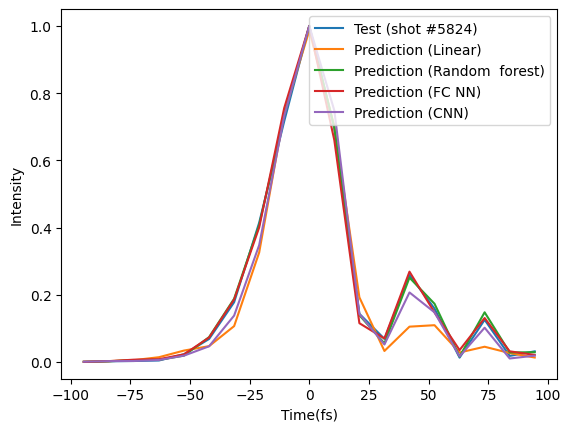

In [57]:
plot_example(225,y_test,y_test_reset,df_input_clean,df_time_val,
             y_predict_lin_backforw,y_predict_backforw,y_predict_fcnn_backforw,y_predict_cnn_backforw)

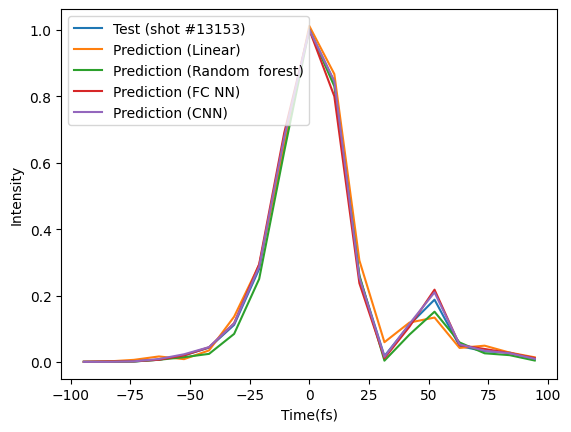

In [30]:
plot_example(238,y_test,y_test_reset,df_input_clean,df_time_val,
             y_predict_lin_backforw,y_predict_backforw,y_predict_fcnn_backforw,y_predict_cnn_backforw)

### plot the same for the paper

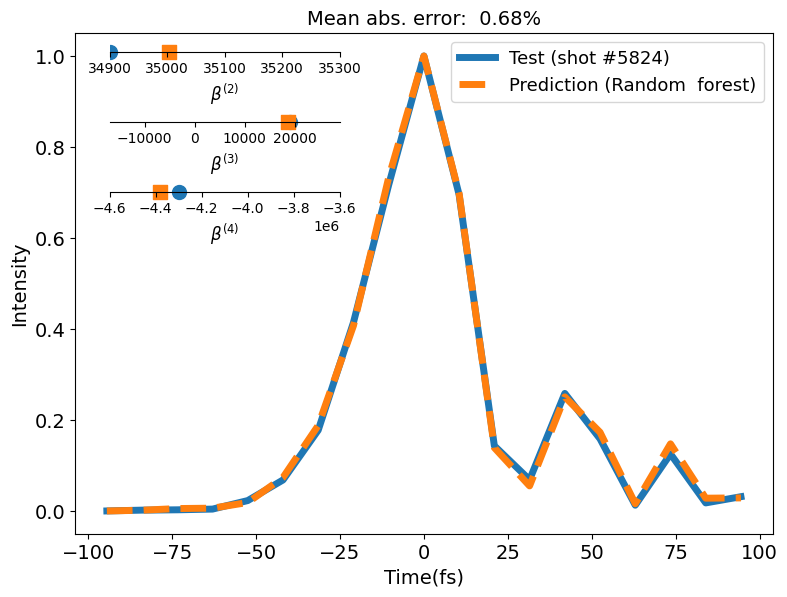

In [266]:
plot_example_2(225,y_test,y_test_reset,df_input_clean,df_time_val,
             y_predict_backforw,X_predict_forest_backward)

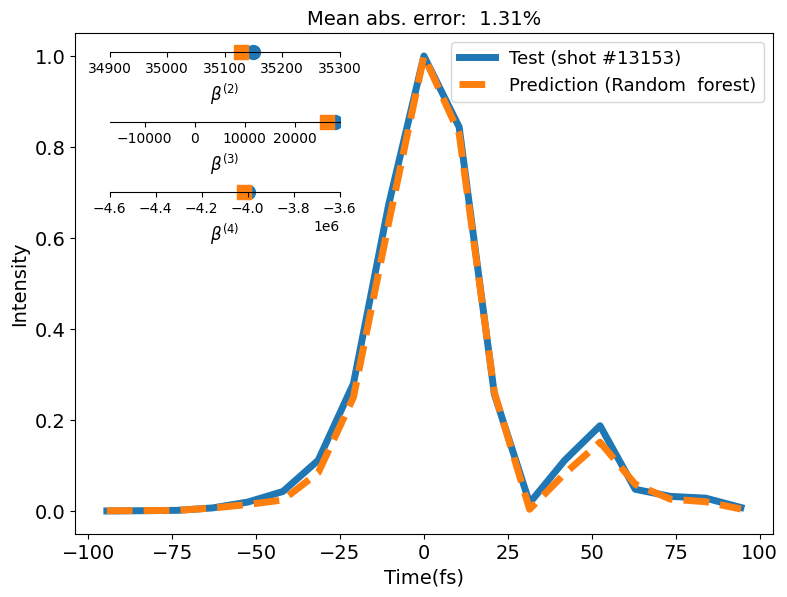

In [267]:
plot_example_2(238,y_test,y_test_reset,df_input_clean,df_time_val,
             y_predict_backforw,X_predict_forest_backward)

## Error distribution

### linear model

In [31]:
#study the erro distribution
df_error_backforw_lin=abs(y_test_reset-y_predict_lin_backforw)
df_error_backforw_lin=df_error_backforw_lin.sum(axis=1)/y_test.shape[1] #sum error / num columns
print(df_error_backforw_lin)

print(df_error_backforw_lin.idxmax())
print(df_error_backforw_lin.max())

0       0.036825
1       0.032472
2       0.031236
3       0.014767
4       0.032237
          ...   
3640    0.028932
3641    0.012871
3642    0.023056
3643    0.021987
3644    0.032514
Length: 3645, dtype: float64
3460
0.15687578529522048


### random forest

In [32]:
#study the erro distribution
df_error_backforw_forest=abs(y_test_reset-y_predict_backforw)
df_error_backforw_forest=df_error_backforw_forest.sum(axis=1)/y_test.shape[1] #sum error / num columns
print(df_error_backforw_forest)

print(df_error_backforw_forest.idxmax())
print(df_error_backforw_forest.max())

0       0.010567
1       0.005699
2       0.009925
3       0.007962
4       0.005686
          ...   
3640    0.007758
3641    0.007991
3642    0.009502
3643    0.003357
3644    0.012474
Length: 3645, dtype: float64
1228
0.12746206877206911


### FC NN

In [33]:
#study the erro distribution
df_error_backforw_fcnn=abs(y_test_reset-y_predict_fcnn_backforw)
df_error_backforw_fcnn=df_error_backforw_fcnn.sum(axis=1)/y_test.shape[1] #sum error / num columns
print(df_error_backforw_fcnn)

print(df_error_backforw_fcnn.idxmax())
print(df_error_backforw_fcnn.max())

0       0.015527
1       0.015301
2       0.002145
3       0.019319
4       0.009053
          ...   
3640    0.010394
3641    0.017685
3642    0.003369
3643    0.004231
3644    0.008229
Length: 3645, dtype: float64
3413
0.12842445488680032


### CNN

In [34]:
#study the erro distribution
df_error_backforw_cnn=abs(y_test_reset-y_predict_cnn_backforw)
df_error_backforw_cnn=df_error_backforw_cnn.sum(axis=1)/y_test.shape[1] #sum error / num columns
print(df_error_backforw_cnn)

print(df_error_backforw_cnn.idxmax())
print(df_error_backforw_cnn.max())

0       0.006952
1       0.018278
2       0.012894
3       0.018069
4       0.008437
          ...   
3640    0.006640
3641    0.016557
3642    0.007468
3643    0.005759
3644    0.015508
Length: 3645, dtype: float64
1228
0.13452637840058462


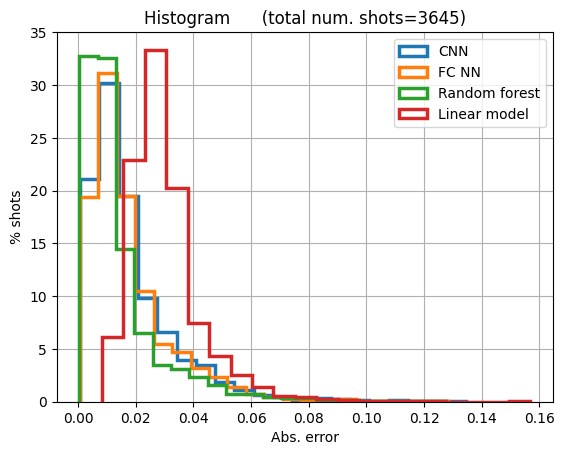

In [35]:
weights_backforw_cnn = 100*np.ones_like(df_error_backforw_cnn) / len(df_error_backforw_cnn)
weights_backforw_fcnn = 100*np.ones_like(df_error_backforw_fcnn) / len(df_error_backforw_fcnn)
weights_backforw_forest = 100*np.ones_like(df_error_backforw_forest) / len(df_error_backforw_forest)
weights_backforw_lin = 100*np.ones_like(df_error_backforw_lin) / len(df_error_backforw_lin)
df_error_backforw_cnn.hist(bins=20,weights=weights_backforw_cnn,histtype="step",linewidth=2.5,label='CNN')
df_error_backforw_fcnn.hist(bins=20,weights=weights_backforw_fcnn,histtype="step",linewidth=2.5,label='FC NN')
df_error_backforw_forest.hist(bins=20,weights=weights_backforw_forest,histtype="step",linewidth=2.5,label='Random forest')
df_error_backforw_lin.hist(bins=20,weights=weights_backforw_lin,histtype="step",linewidth=2.5, label='Linear model')
plt.ylabel('% shots')
plt.xlabel('Abs. error')
plt.title('Histogram      (total num. shots='+str(len(df_error_backforw_forest))+')')
plt.legend()

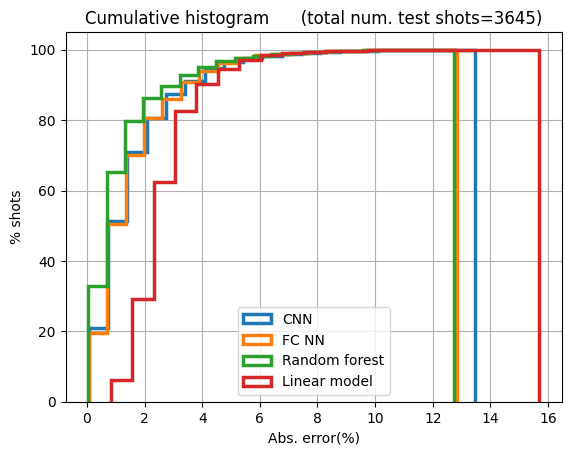

The average error in the CNN is 1.83%
The average error in the FC NN is 1.79%
The average error in the Random forest is 1.44%
The average error in the linear model is 3.01%
 
 


In [251]:
weights_backforw_cnn = 100*np.ones_like(df_error_backforw_cnn) / len(df_error_backforw_cnn)
weights_backforw_fcnn = 100*np.ones_like(df_error_backforw_fcnn) / len(df_error_backforw_fcnn)
weights_backforw_forest = 100*np.ones_like(df_error_backforw_forest) / len(df_error_backforw_forest)
weights_backforw_lin = 100*np.ones_like(df_error_backforw_lin) / len(df_error_backforw_lin)
(100*df_error_backforw_cnn).hist(bins=20,weights=weights_backforw_cnn,cumulative=True,histtype="step",linewidth=2.5,label='CNN')
(100*df_error_backforw_fcnn).hist(bins=20,weights=weights_backforw_fcnn,cumulative=True,histtype="step",linewidth=2.5,label='FC NN')
(100*df_error_backforw_forest).hist(bins=20,weights=weights_backforw_forest,cumulative=True,histtype="step",linewidth=2.5,label='Random forest')
(100*df_error_backforw_lin).hist(bins=20,weights=weights_backforw_lin,cumulative=True,histtype="step",linewidth=2.5, label='Linear model')
plt.ylabel('% shots')
plt.xlabel('Abs. error(%)')
plt.title('Cumulative histogram      (total num. test shots='+str(len(df_error_backforw_forest))+')')
plt.legend()
plt.show()

avg_error_cnn=100*df_error_backforw_cnn.mean()
avg_error_fcnn=100*df_error_backforw_fcnn.mean()
avg_error_forest=100*df_error_backforw_forest.mean()
avg_error_lin=100*df_error_backforw_lin.mean()
print('The average error in the CNN is {:4.2f}%'.format(avg_error_cnn))
print('The average error in the FC NN is {:4.2f}%'.format(avg_error_fcnn))
print('The average error in the Random forest is {:4.2f}%'.format(avg_error_forest))
print('The average error in the linear model is {:4.2f}%'.format(avg_error_lin))
print(' ')
print(' ')

## Error distribution in the parameter space

We want to see if there is any correlation between the largest error shots and its parameters

In [255]:
temp_error_forest=df_error_backforw_forest.copy()
temp_error_forest.to_frame()
temp_error_forest=temp_error_forest.set_axis(y_test.index)
print(temp_error_forest)
df_error_distr=X_test.copy()
df_error_distr['error prediction']=temp_error_forest
df_error_distr=df_error_distr[df_error_distr['error prediction']>0.01]
df_error_distr

23       0.010567
4273     0.005699
1046     0.009925
9925     0.007962
4816     0.005686
           ...   
6828     0.007758
4559     0.007991
4014     0.009502
3894     0.003357
10701    0.012474
Length: 3645, dtype: float64


,order2,order3,order4,error prediction
23,34900,-17000,-3900000.0,0.010567
3798,35000,19000,-4200000.0,0.023112
4087,35000,29000,-4300000.0,0.017652
375,34900,-5000,-3800000.0,0.014314
11575,35300,1000,-3900000.0,0.022268
...,...,...,...,...
4777,35050,5000,-3700000.0,0.013169
6607,35100,21000,-4300000.0,0.022813
2933,35000,-11000,-3800000.0,0.010638
2846,35000,-14000,-3700000.0,0.012395


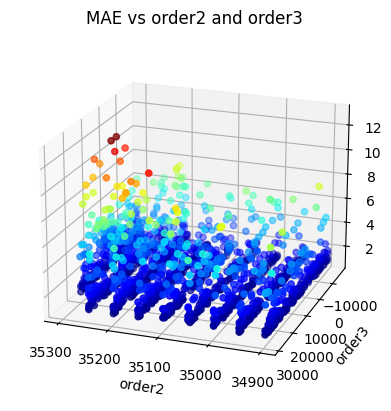

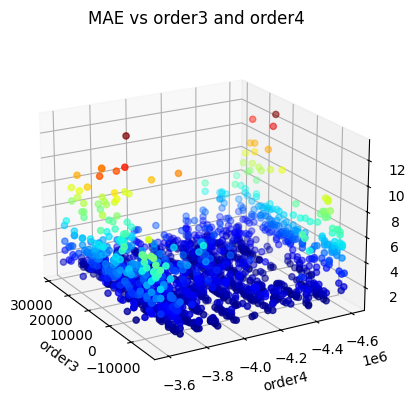

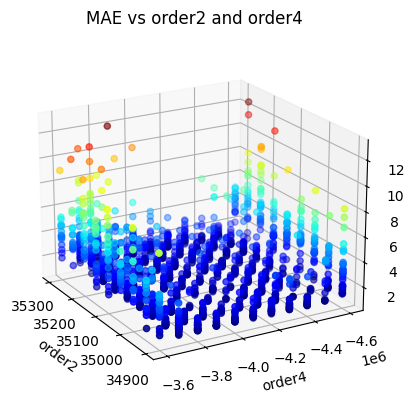

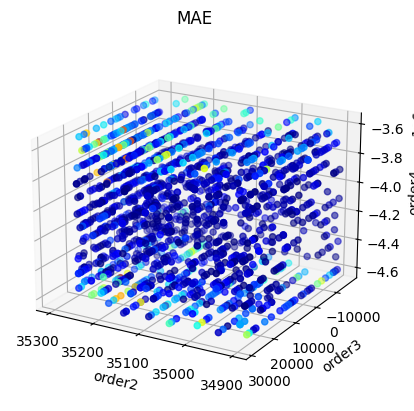

In [256]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df_error_distr['order2'], df_error_distr['order3'], 100*df_error_distr['error prediction'],c=100*df_error_distr['error prediction'],cmap='jet')
ax.set_xlabel('order2')
ax.set_ylabel('order3')
ax.set_zlabel('Error')
ax.view_init(elev=20., azim=110)
plt.title('MAE vs order2 and order3')
plt.show()

fig = plt.figure()
ax2 = fig.add_subplot(projection='3d')
ax2.scatter(df_error_distr['order3'], df_error_distr['order4'], 100*df_error_distr['error prediction'],c=100*df_error_distr['error prediction'],cmap='jet')
ax2.set_xlabel('order3')
ax2.set_ylabel('order4')
ax2.set_zlabel('Error')
ax2.view_init(elev=20., azim=150)
plt.title('MAE vs order3 and order4')
plt.show()

fig = plt.figure()
ax3 = fig.add_subplot(projection='3d')
ax3.scatter(df_error_distr['order2'], df_error_distr['order4'], 100*df_error_distr['error prediction'],c=100*df_error_distr['error prediction'],cmap='jet')
ax3.set_xlabel('order2')
ax3.set_ylabel('order4')
ax3.set_zlabel('Error')
ax3.view_init(elev=20., azim=150)
plt.title('MAE vs order2 and order4')
plt.show()

fig = plt.figure()
ax4 = fig.add_subplot(projection='3d')
ax4.scatter(df_error_distr['order2'], df_error_distr['order3'], df_error_distr['order4'],c=100*df_error_distr['error prediction'],cmap='jet')
ax4.set_xlabel('order2')
ax4.set_ylabel('order3')
ax4.set_zlabel('order4')
ax4.view_init(elev=20., azim=120)
plt.title('MAE')
#plt.tight_layout()
plt.show()

## Test shots (Apr 12)

In [39]:
#X are dazzler param, y is intensity

In [40]:
def plot_test_shot_and_predictions(y_test_shot):
    ###  random forest
    X_predict_shot_forest=forest_regr_backward.predict(y_test_shot) #backward prediction
    y_predict_shot_forest=forest_regr_forward.predict(X_predict_shot_forest) #forward prediction
    #print(y_predict_shot0)

    ###  FCNN
    #first convert to tensor
    y_test_shot_tensor=torch.tensor(y_test_shot)#.values,dtype=torch.float32)
    y_test_shot_tensor=y_test_shot_tensor.to(device)
    X_predict_shot_fcnn_tensor=nn_fc_model(y_test_shot_tensor)
    X_predict_shot_fcnn_reg=X_predict_shot_fcnn_tensor.detach().cpu().numpy()
    #Revert the target normalization
    X_predict_shot_fcnn=X_predict_shot_fcnn_reg.copy()
    X_predict_shot_fcnn[:,0]=(X_predict_shot_fcnn_reg[:,0]*X_train['order2'].std())+X_train['order2'].mean()
    X_predict_shot_fcnn[:,1]=(X_predict_shot_fcnn_reg[:,1]*X_train['order3'].std())+X_train['order3'].mean()
    X_predict_shot_fcnn[:,2]=(X_predict_shot_fcnn_reg[:,2]*X_train['order4'].std())+X_train['order4'].mean()
    y_predict_shot_fcnn=forest_regr_forward.predict(X_predict_shot_fcnn) #forward prediction

    ### CNN
    X_predict_shot_cnn_tensor=cnn_model(y_test_shot_tensor.unsqueeze(1))
    X_predict_shot_cnn_reg=X_predict_shot_cnn_tensor.detach().cpu().numpy()
    #Revert the target normalization
    X_predict_shot_cnn=X_predict_shot_cnn_reg.copy()
    X_predict_shot_cnn[:,0]=(X_predict_shot_cnn_reg[:,0]*X_train['order2'].std())+X_train['order2'].mean()
    X_predict_shot_cnn[:,1]=(X_predict_shot_cnn_reg[:,1]*X_train['order3'].std())+X_train['order3'].mean()
    X_predict_shot_cnn[:,2]=(X_predict_shot_cnn_reg[:,2]*X_train['order4'].std())+X_train['order4'].mean()
    y_predict_shot_cnn=forest_regr_forward.predict(X_predict_shot_cnn) #forward prediction


    plt.plot(df_time_val,y_test_shot[0],label='Test shot')
    plt.plot(df_time_val,y_predict_shot_forest[0],label='Prediction round-trip RF')
    plt.plot(df_time_val,y_predict_shot_fcnn[0],label='Prediction round-trip FC NN')
    plt.plot(df_time_val,y_predict_shot_cnn[0],label='Prediction round-trip CNN')
    mae='{:6.5f}'.format(mean_absolute_error(y_test_shot,y_predict_shot_forest))
    #plt.title('Mean abs. error:'+mae)
    plt.xlabel('Time(fs)')
    plt.ylabel('Intensity')
    plt.legend()

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


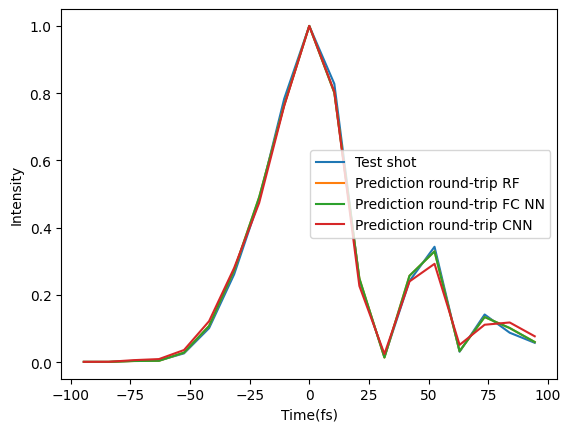

In [41]:
#shot0
y_test_shot0=[[0.001199,0.00104,0.004285,0.005213,0.026507,0.101424,0.261314,0.482225,0.783666,1.0,0.82783,0.244637,0.016048,0.241497,0.34343,0.031268,0.142042,0.087892,0.057908]]
plot_test_shot_and_predictions(y_test_shot0)

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


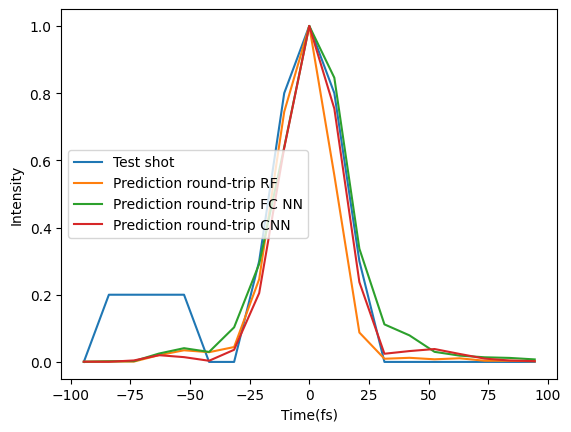

In [42]:
#shot1
y_test_shot1=[[0,0.2,0.2,0.2,0.2,0,0,0.3,0.8,1,0.8,0.3,0,0,0,0,0,0,0]]
plot_test_shot_and_predictions(y_test_shot1)

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


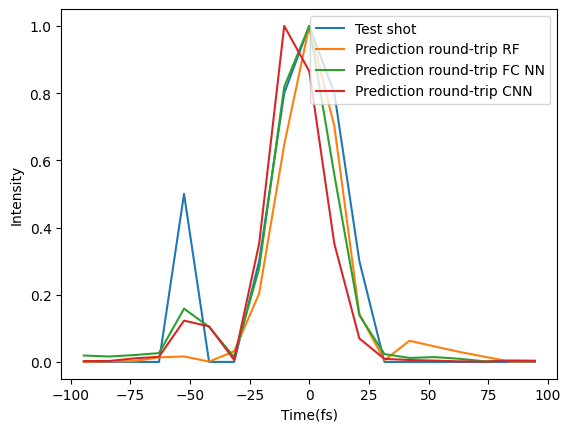

In [43]:
#shot2
y_test_shot2=[[0,0,0,0,0.5,0,0,0.3,0.8,1,0.8,0.3,0,0,0,0,0,0,0]]
plot_test_shot_and_predictions(y_test_shot2)

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


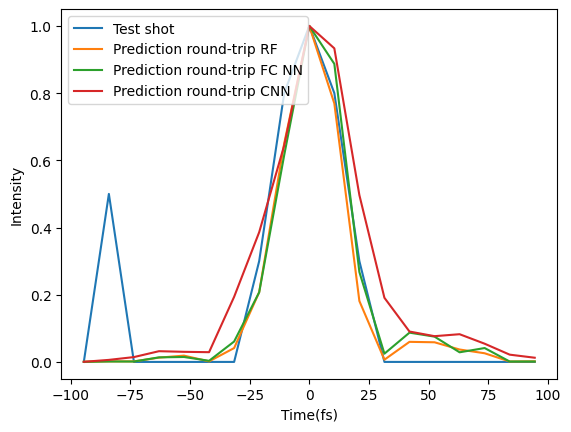

In [44]:
#shot3
y_test_shot3=[[0,0.5,0,0,0,0,0,0.3,0.8,1,0.8,0.3,0,0,0,0,0,0,0]]
plot_test_shot_and_predictions(y_test_shot3)

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


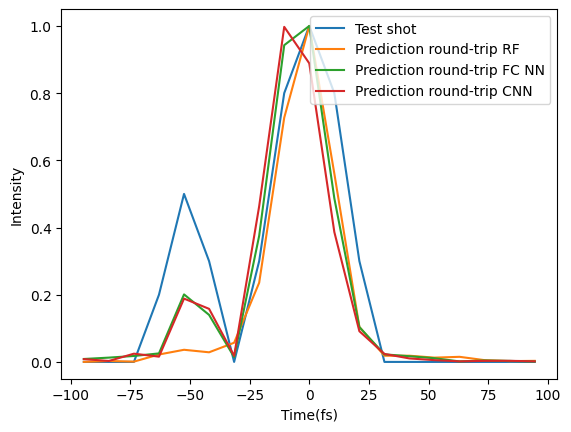

In [45]:
#shot4 (checking myself
y_test_shot4=[[0,0,0,0.2,0.5,0.3,0,0.3,0.8,1,0.8,0.3,0,0,0,0,0,0,0]]
plot_test_shot_and_predictions(y_test_shot4)